In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import sinkhorn as skh
import oracles as oracle
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [3]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 3, 4]))
# graph_data['graph_table']['Capacity'] = 2.5 * graph_data['graph_table']['Capacity']

graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [4]:
graph_data['graph_table'].head()

,Init node,Term node,Capacity,length,Free Flow Time
0,1,3,4938.061523,16.106817,0.238965
1,3,1,5254.128418,16.057131,0.240297
2,1,7,7309.824707,16.058741,0.222813
3,7,1,7388.626953,15.865263,0.218902
4,1,9,1164.374878,17.455400,0.402046


In [5]:
graph_data['graph_table']['Orig Free Flow Time'] = graph_data['graph_table']['Free Flow Time']

In [6]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,length,Free Flow Time,Orig Free Flow Time
0,1,3,4938.061523,16.106817,0.238965,0.238965
2,1,7,7309.824707,16.058741,0.222813,0.222813
4,1,9,1164.374878,17.455400,0.402046,0.402046


In [7]:
correspondence_matrix = handler.from_dict_to_cor_matr(graph_correspondences, n)
T = handler.create_C(df, n, column_name='Free Flow Time')
C = handler.create_C(df, n, column_name='length')
np.savetxt('data/T.csv', T, delimiter=',')

L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)

people_num = np.nansum(L)

L = handler.distributor_L_W(L)
W = handler.distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)

print('people_num: ', people_num)

people_num:  65576.37543100001


In [8]:
T[0][6], C[0][6]

(0.22281299531459808, 16.058740615844727)

##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Поэтому альфа получается таким большим, оно масштабирует. В Москве время было в минутах. Также в T много нулей, поэтому там, где стоят nan, поставим по 100 часов, типа много затрат и поэтому никто так не ездит (сделано там, где инициализируется cost_matrix)

##### Запускаем Синхорна-Универсальный

In [9]:
def count_alpha(i, T, T_prev, T_orig, alpha_prev, alpha_prev_prev):
    alpha = None
    C_star = np.nanmean(T_orig)
    
    if i == 0:
        alpha = 1 / C_star
        return alpha
    
    C_m = np.nanmean(T)
    if i == 1:
        alpha = (alpha_prev * C_m) / C_star
        return alpha
    
    C_m_prev = np.nanmean(T_prev)
    alpha = ( (C_star - C_m_prev) * alpha_prev + 
             (C_m - C_star) * alpha_prev_prev ) / (C_m - C_m_prev)
    return alpha

In [10]:
np.set_printoptions(formatter={'all':lambda x: str(x)})
multistage_er = np.inf
eps = 10**(-5)
multistage_er_list = []
result_history = []
best_reconstruction_error_history = []
multi_stage_i = 0

T_orig = T
T_prev = None
T = None
alpha = None
alpha_prev = None
alpha_prev_prev = None
buf = None

best_matrix = None
min_reconstruction_error = np.inf
er_list = []
alpha_list = []
time_ratio_list = []
flow_excess_list = []

num_iter = 2500  # for sink
max_iter = 1 # for univ

while multistage_er > eps or multi_stage_i < 13:
    print('iter of multi-stage num: ', multi_stage_i)
    
    multistage_er = None
    
    s = skh.Sinkhorn(n, L, W, people_num, num_iter, eps)
    
    alpha = count_alpha(multi_stage_i, T, T_prev, T_orig, alpha_prev, alpha_prev_prev)
    alpha_list.append(alpha)
    print(alpha, alpha_prev, alpha_prev_prev)
    
    T_prev = T
    buf = alpha_prev
    alpha_prev = alpha
    alpha_prev_prev = buf
    
    if multi_stage_i == 0: 
        cost_matrix = np.nan_to_num( alpha * T_orig, nan=100)
    else:
        cost_matrix = np.nan_to_num( alpha * T, nan=100)
    
    rec = s.iterate(cost_matrix)    
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er = np.sqrt(er / np.sum (np.nan_to_num(correspondence_matrix, nan=0.0)))
    er_list.append(er)

    best_matrix = rec
    
    best_correcpondences_dict = handler.from_cor_matrix_to_dict(best_matrix)
    
    print('Sinkhorn end, univ start \n')
    print('alpha: ', alpha)
    print('reconstruction error: ', er)

    model = md.Model(graph_data, best_correcpondences_dict, 
                     total_od_flow, mu = 0.25, rho = 0.15) # B, for stable D mu=0.0
    
    for i, eps_abs in enumerate(np.logspace(1,3,1)):
        
        print('eps_abs =', eps_abs)
        solver_kwargs = {'eps_abs': eps_abs,
                         'max_iter': max_iter}
        tic = time.time()
        result = model.find_equilibrium(solver_name = 'ugd', 
                                        solver_kwargs = solver_kwargs, 
                                        verbose = False)
        
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result
                                    ['times'] / graph_data['graph_table']
                                    ['Free Flow Time']))
    
    time_ratio_list.append(np.max(result
                                    ['times'] / graph_data['graph_table']
                                    ['Free Flow Time']))

    print('Flow excess =', np.max(result
                                    ['flows'] / graph_data['graph_table']
                                    ['Capacity']) - 1, end = '\n\n')
    
    flow_excess_list.append(np.max(result
                                    ['flows'] / graph_data['graph_table']
                                    ['Capacity']) - 1)
    
    multistage_er = np.linalg.norm(graph_data['graph_table']
                                           ['Free Flow Time'].as_matrix()
                                - result['times'])
    
    print('C-error: ' , multistage_er)
    multistage_er_list.append(multistage_er)
    result_history.append(result)
    
    graph_data['graph_table']['Free Flow Time'] = result['times']
    
    print('sum T before univ: ', np.sum(np.nan_to_num(T, nan=0.0)))
    T = handler.create_C(graph_data['graph_table'], 
                         n, column_name='Free Flow Time')
    print('sum T  after univ: ', np.sum(np.nan_to_num(T, nan=0.0)))
    
    multi_stage_i += 1

iter of multi-stage num:  0
5.808926170432106 None None
Sinkhorn end, univ start 

alpha:  5.808926170432106
reconstruction error:  0.33816639653732805
eps_abs = 10.0


/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pred_edges' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py", line 26:
@njit
def get_flows(nodes_number, edges_number, targets, target_flows, pred_arr, pred_edges, sorted_vertices):  
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_vertices' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py"

Elapsed time: 8 sec
Time ratio = 1.00205805994698
Flow excess = 4.5056028414462785

C-error:  0.0005088827424160384
sum T before univ:  None
sum T  after univ:  44.41709909097777
iter of multi-stage num:  1
5.809278518374841 5.808926170432106 None
Sinkhorn end, univ start 

alpha:  5.809278518374841
reconstruction error:  0.3381663817675426
eps_abs = 10.0
Elapsed time: 7 sec
Time ratio = 1.002054459476535
Flow excess = 4.505558980900875

C-error:  0.000508902368603328
sum T before univ:  44.41709909097777
sum T  after univ:  44.41979324076921
iter of multi-stage num:  2
5.808573840342442 5.809278518374841 5.808926170432106
Sinkhorn end, univ start 

alpha:  5.808573840342442
reconstruction error:  0.3381659043832557
eps_abs = 10.0
Elapsed time: 7 sec
Time ratio = 1.0020508919240123
Flow excess = 4.505539315331456

C-error:  0.0005087287850191887
sum T before univ:  44.41979324076921
sum T  after univ:  44.42248638373805
iter of multi-stage num:  3
5.810688365604161 5.808573840342442 5.

/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:32: RuntimeWarning: overflow encountered in exp
  (np.exp(-lambda_W_prev - 1 - cost_matrix)).T
/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:56: RuntimeWarning: invalid value encountered in subtract
  delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L,
/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:33: RuntimeWarning: overflow encountered in true_divide
  / self.L, axis=0
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:39: RuntimeWarning: divide by zero encountered in log
  / self.W, axis=0
/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:57: RuntimeWarning: invalid value encountered in subtract
  lambda_Wn - lambda_W)))
/Users/kate/PycharmProjects/TransportNet-master/sinkhorn.py:68: RuntimeWarnin

Sinkhorn end, univ start 

alpha:  -1822.4923990758987
reconstruction error:  nan
eps_abs = 10.0


ZeroDivisionError: division by zero

In [11]:
alpha_list

[5.808926170432106,
 5.809278518374841,
 5.808573840342442,
 5.810688365604161,
 5.802229079007043,
 5.844527676632548,
 5.590710158875926,
 7.366364755163295,
 -6.88852794588558,
 211.35692220019715,
 -1822.4923990758987]

In [12]:
multistage_er_list

[0.0005088827424160384,
 0.000508902368603328,
 0.0005087287850191887,
 0.0005087451472379557,
 0.0005087808179353252,
 0.0005087237376002315,
 0.0005092114657886757,
 0.0005061537034071634,
 0.00027568197518012643,
 0.0005024198720475754]

11 10


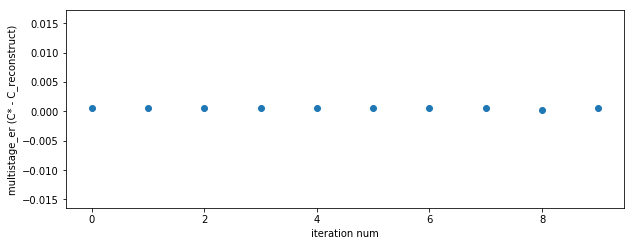

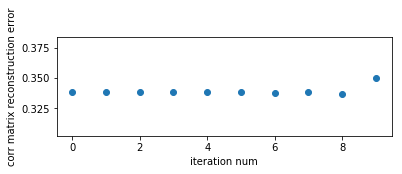

In [14]:
print(len(alpha_list), len(multistage_er_list) )
fig = plt.figure(figsize=(10, 8))
plt.figure(1)
plt.subplot(211)
plt.scatter(range(len(multistage_er_list)), multistage_er_list)
plt.ylabel('multistage_er (C* - C_reconstruct)')
plt.xlabel('iteration num')
# plt.ylim(0, 0.0005)
# fig.savefig('KEV_res/multistage_er.png')
plt.figure(2)
plt.subplot(212)
plt.scatter(range(len(er_list)), er_list)
plt.ylabel('corr matrix reconstruction error')
plt.xlabel('iteration num')
plt.show()
# fig.savefig('KEV_res/sink_reconstruct_er.png')

In [ ]:
er_list

In [ ]:
print(len(alpha_list), len(er_list))
fig = plt.figure(figsize=(10, 8))
plt.scatter(range(len(er_list)), er_list)
plt.ylabel('reconstruction error')
plt.xlabel('iteration num')
plt.show()
# fig.savefig('KEV_res/multi-stage-2-' + str(alpha) + 
#             'corr matrix reconstruction error' + '.png')